Task Breakdown:
* Barcode Detection* (I will not use some AI to save computational power)
* Barcode Decoding - Extract the numerical code. Own implementation

Test my solution against benchmark solutions - Pyzbar, Zxing, Dynamsoft..

Input:
* All images from the current folder.
Output:
* A text or CSV file containing the decoded numbers, indexed by image filename
* Example output images with optional visualizations (e.g., detection boxes, signal profiles, etc.)


In [567]:
import numpy as np
import cv2, os

def create_input_list(input_dir):
    input_list = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.jpeg'):
                input_list.append(os.path.join(root, file))
    return input_list


input_directory = r'/home/costin/Documents/Github/ComputerVision/2_barcodes'
images = create_input_list(input_directory)
print(f"Found {len(images)} images:")

Found 6 images:


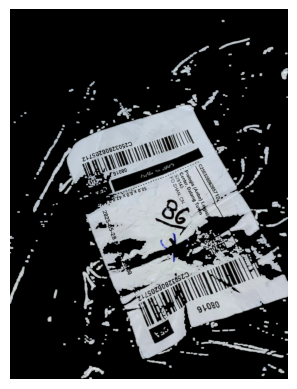

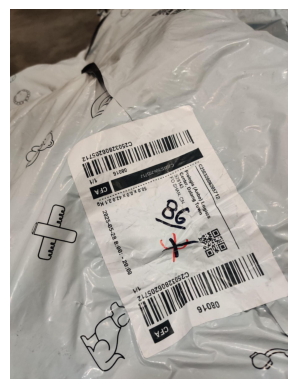

In [568]:
def preprocessing(image_path):
    img = cv2.imread(image_path).copy()
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # HSV = Hue, Saturation, Value
    msk = cv2.inRange(hsv, np.array([0, 0, 200]), np.array([179, 60, 255])) # Isolate white-like regions
    msk = cv2.GaussianBlur(msk, (5, 5), 0) # Much better results with GaussianBlur than median blur
    # Morph to connect broken pieces
    krn = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 3))
    dlt = cv2.dilate(msk, krn, iterations=1)

    return cv2.bitwise_and(img, img, mask=dlt)

import random
random_image = images[random.randint(0, len(images) - 1)]
preprocessed_image = preprocessing(random_image) # run multiple times to see different results.
import matplotlib.pyplot as plt
plt.imshow(preprocessed_image)
plt.axis('off')
plt.show()
# Show original image as well
original_image = cv2.imread(random_image)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

(-0.5, 851.5, 850.5, -0.5)

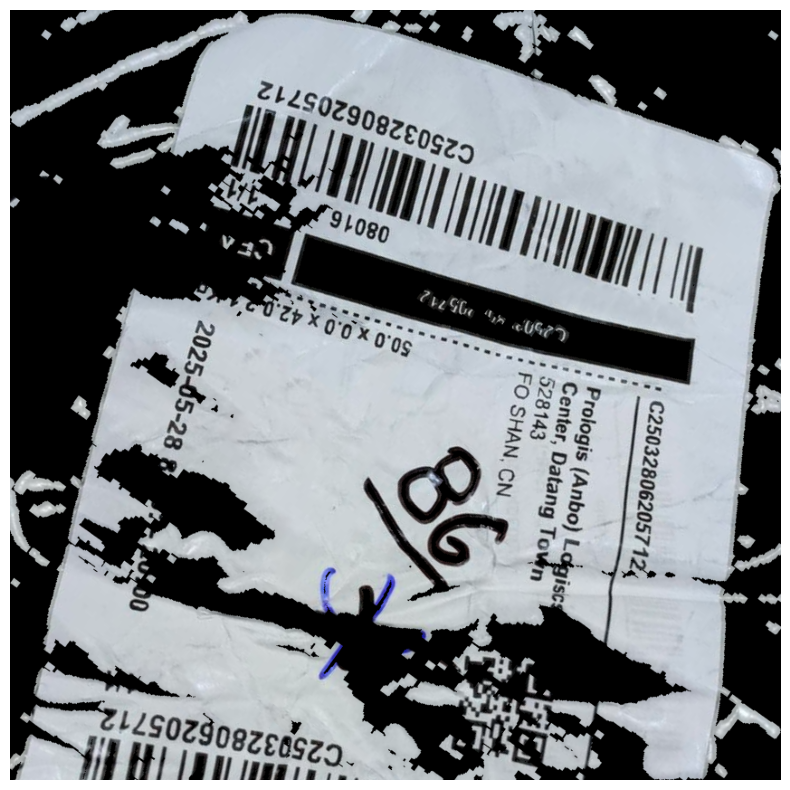

In [569]:
def extract_largest_white_region(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_area = 10000 # Empirical value
    large_contours = [c for c in contours if cv2.contourArea(c) > min_area]

    # Stack all large contours together. Source: https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html - section 7.b
    best_contour = max(large_contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(best_contour) # Get the minimum-area rotated rectangle around all contours
    box = cv2.boxPoints(rect)
    box = np.intp(box) # int0 is deprecated
    # extract width and height of the rect. rect = [center, (width, height), and angle]
    width = int(rect[1][0])
    height = int(rect[1][1])
    angle = rect[2]

    if height > width: # Ensure width > height. Otherwise, rotation doesn't really make sense.
        width, height = height, width
        box = np.roll(box, 1, axis=0)

    # Define destination points for perspective transform
    dst_pts = np.array([
        [0, height - 1], # bottom-left
        [0, 0], # top-left
        [width - 1, 0], # top-right
        [width - 1, height - 1] # bottom-right
        ], dtype="float32")

    src_pts = box.astype("float32")
    M = cv2.getPerspectiveTransform(src_pts, dst_pts) # Transformation matrix. Includes rotation, scaling, and translation.
    warped = cv2.warpPerspective(image, M, (width, height))
    return warped

roi_image = extract_largest_white_region(preprocessed_image)
plt.figure(figsize=(10, 10))
plt.imshow(roi_image)
plt.axis('off')

Found 1637 parallel lines.


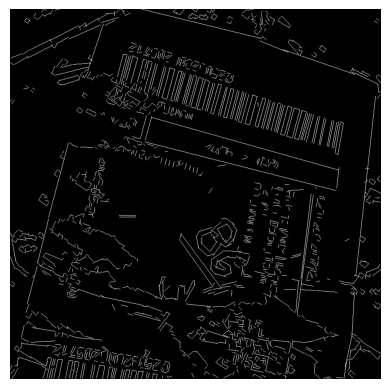

In [570]:
"""
Find the barcode region in the preprocessed image
I will use LSD (Line Segment Detector) to find the barcode region.
Source:
https://www.ipol.im/pub/art/2012/gjmr-lsd/article.pdf
https://github.com/costineesti/SeaClear/blob/main/scripts/grid_detection.py
https://costinchitic.co/notes/Line-Segment-Detector
"""

def sort_lsd_lines(lsd_lines, angle_threshold=3):
    """
    Return only lines that are parallel to each other.
    Groups lines by similar angles and returns the largest group.
    """
    if lsd_lines is None or len(lsd_lines) == 0:
        return [], []
    
    # Calculate angle and length for each line
    line_data = []
    for line in lsd_lines:
        x1, y1, x2, y2 = line[0]
        length = np.sqrt((x2-x1)**2 + (y2-y1)**2)
        angle = np.degrees(np.arctan2(y2-y1, x2-x1))
        
        # Normalize angle to [0, 180) range
        angle = angle % 180

        # if length > 30 and length < 100 and abs(angle - last_angle) < angle_threshold:
        line_data.append({
            'line': line,
            'angle': angle,
            'length': length
        })
        
        last_angle = angle
    
    # Only keep lines that have similar lengths!
    return line_data

def find_barcode_region(barcode_image):
    gray = cv2.cvtColor(barcode_image, cv2.COLOR_BGR2GRAY)
    lsd = cv2.createLineSegmentDetector(0)
    lsd_lines = lsd.detect(gray)[0]
    
    if lsd_lines is None:
        return None
    
    parallel_lines = sort_lsd_lines(lsd_lines)
    # See what we have so far
    print(f"Found {len(parallel_lines)} parallel lines.")
    # Draw lines on the image
    lsd_image = np.zeros_like(barcode_image)
    lsd_image = cv2.cvtColor(lsd_image, cv2.COLOR_BGR2GRAY)
    for line in parallel_lines:
        x1, y1, x2, y2 = line['line'][0]
        cv2.line(lsd_image, (int(x1), int(y1)), (int(x2), int(y2)), 255, 1)
    plt.imshow(lsd_image, cmap='gray')
    plt.axis('off')
    plt.show()

    return cv2.cvtColor(lsd_image, cv2.COLOR_GRAY2BGR)

lsd_image = find_barcode_region(roi_image)

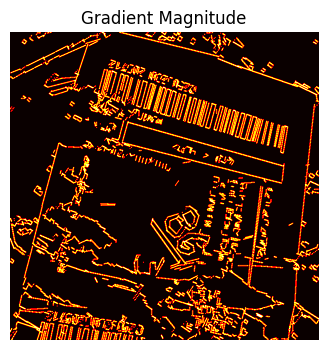

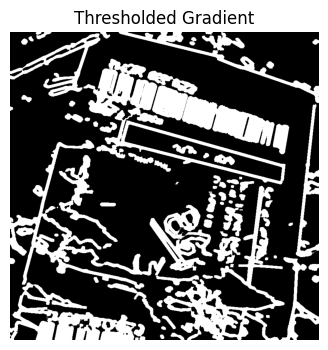

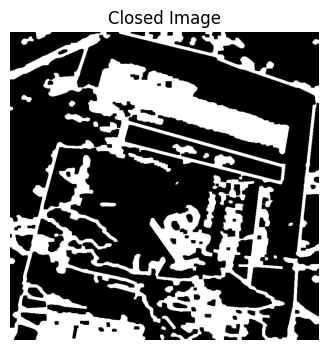

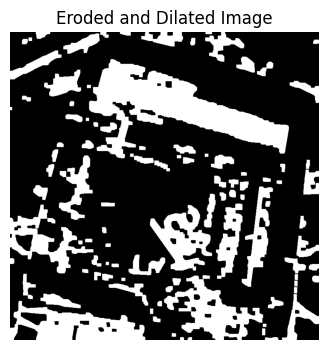

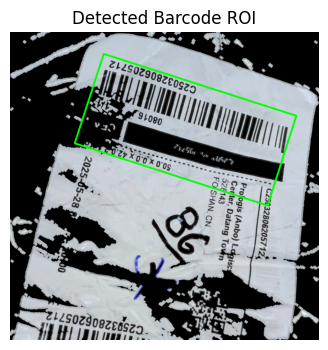

In [571]:
def find_barcode_by_gradient(image):
    """
    Find and return the straightened barcode ROI
    Source: https://www.reddit.com/r/computervision/comments/sw46hn/barcode_detection/
    Which led to this implementation: https://pyimagesearch.com/wp-content/uploads/2015/01/the-ultimate-barcode-detection-guide.pdf
    """
    # Grayscale + Sobel
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gradX   = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=-1)
    gradY   = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=-1)
    # subtract the y-gradient from the x-gradient
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)

    plt.figure(figsize=(4,4))
    plt.imshow(gradient, cmap='hot')
    plt.title("Gradient Magnitude"); plt.axis('off'); plt.show()

    blurred = cv2.blur(gradient, (11, 9))
    (_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_OTSU)

    plt.figure(figsize=(4,4))
    plt.imshow(thresh, cmap='gray')
    plt.title("Thresholded Gradient"); plt.axis('off'); plt.show()

    # construct a closing kernel and apply it to the thresholded image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    plt.figure(figsize=(4,4))
    plt.imshow(closed, cmap='gray')
    plt.title("Closed Image"); plt.axis('off'); plt.show()

    # perform a series of erosions and dilations
    closed = cv2.erode(closed, None, iterations = 4)
    closed = cv2.dilate(closed, None, iterations = 4)

    plt.figure(figsize=(4,4))
    plt.imshow(closed, cmap='gray')
    plt.title("Eroded and Dilated Image"); plt.axis('off'); plt.show

    # find the contours in the thresholded image, then sort the contours
    # by their area, keeping only the largest one
    (cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    rect = cv2.minAreaRect(c)
    box = np.intp(cv2.boxPoints(rect))

    return box

# Example usage
barcode_roi = find_barcode_by_gradient(lsd_image)
# Draw the bounding box on the original image
cv2.drawContours(roi_image, [barcode_roi], -1, (0, 255, 0), 3)
plt.figure(figsize=(4,4))
plt.imshow(roi_image)
plt.title("Detected Barcode ROI"); plt.axis('off'); plt.show()